In [2]:
import torch
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt

import gzip
import pickle

from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

import albumentations as albu

import segmentation_models_pytorch as smp

In [4]:
def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [albu.Resize(512, 512, interpolation=2)
#         albu.PadIfNeeded(384, 480)
                      ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)
    
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [947]:
with gzip.open("task3data/test.pkl", 'rb') as f:
    testX= pickle.load(f)

with gzip.open("task3data/sample.pkl", 'rb') as f:
    samples = pickle.load(f)

# load best saved checkpoint
best_model = torch.load('./best_model.pth')

CLASSES=["valve"]
DEVICE = "cuda"

FileNotFoundError: [Errno 2] No such file or directory: './best_model.pth'

In [948]:
with gzip.open("task3data/train.pkl", 'rb') as f:
    trainX= pickle.load(f)

In [6]:
with gzip.open("labelled_train.pkl", 'rb') as f:
    labelled = pickle.load(f)

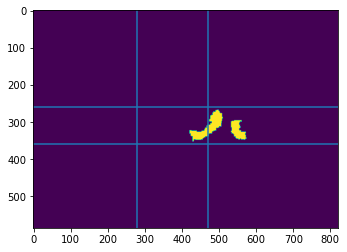

In [998]:
plt.imshow(trainX[50]["label"][:,:,trainX[50]["frames"][0]])
plt.axvline(x=280)
plt.axvline(x=470)
plt.axhline(y=260)
plt.axhline(y=360)

In [995]:
trainX[50]["label"][:,:,trainX[50]["frames"][2]].sum()

4525

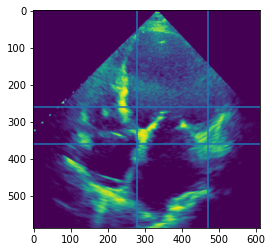

In [984]:
plt.imshow(trainX[47]["video"][:,:,trainX[47]["frames"][1]])
plt.axvline(x=280)
plt.axvline(x=470)
plt.axhline(y=260)
plt.axhline(y=360)

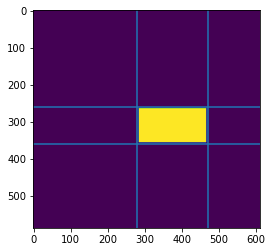

In [975]:
plt.imshow(trainX[47]["box"][:,:])
plt.axvline(x=280)
plt.axvline(x=470)
plt.axhline(y=260)
plt.axhline(y=360)
# plt.axvline(x=340)
# plt.axvline(x=565)
# plt.axhline(y=220)
# plt.axhline(y=340)

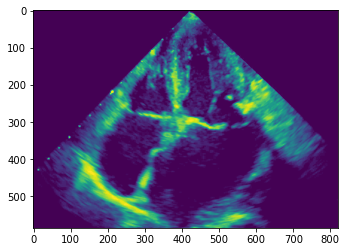

In [7]:
plt.imshow(labelled[50]["video"][:,:,67])

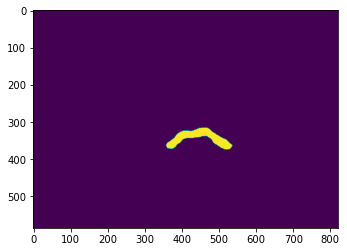

In [8]:
plt.imshow(labelled[50]["label"][:,:,67])

In [9]:

class Dataset3(BaseDataset):
    """mitral valve Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['valve']
    
    def __init__(
            self, 
            data,
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.data = data
        self.images_fps = [pair for pair in self.data]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        image = self.images_fps[i]#[:,:,np.newaxis]
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=np.ones(image.shape))
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing

        if self.preprocessing:
            sample = self.preprocessing(image=image[:,:,np.newaxis], mask=np.ones(image[:,:,np.newaxis].shape))
            image, mask = sample['image'], sample['mask']
        print(image.shape)
        return image
        
    def __len__(self):
        return len(self.data)

In [11]:
test_data = []
for i in range(len(testX)):
    video = testX[i]["video"]
    for j in range(video.shape[2]):
        test_data.append(video[:,:,j])

CLASSES= ["valve"]
test_dataset = Dataset3(
    test_data, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

(3, 512, 512)


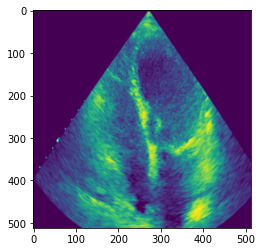

In [12]:
plt.imshow(test_dataset[0][0,:,:])

In [20]:
count =0        
predictions = []
for i in range(2):
    n_frames = testX[i]["video"].shape[2]
    prediction = np.array(np.zeros_like(testX[i]["video"]), dtype=np.bool)
    print(f"GOING INTO {i}th video")
    for j in range(n_frames):
        
        image = test_dataset[count]
        x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
        pr_mask = best_model.predict(x_tensor)
        pr_mask = pr_mask.squeeze().cpu().numpy()
        pr_mask_resized = cv2.resize(pr_mask[:,:,np.newaxis], dsize=testX[i]["video"].shape[:2][::-1], interpolation=cv2.INTER_CUBIC)
        prediction[:,:,j] = pr_mask_resized.round()
        count+=1
        
    predictions.append({
        'name': testX[i]['name'],
        'prediction': prediction
        }
    )
    
    
with gzip.open('my_predictions.pkl', 'wb') as f:
    pickle.dump(predictions, f, 2)

C:\Users\Marios\AppData\Local\Temp/ipykernel_22696/1318706734.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  prediction = np.array(np.zeros_like(testX[i]["video"]), dtype=np.bool)


GOING INTO 0th video
(3, 320, 320)
(3, 320, 320)
(3, 320, 320)
(3, 320, 320)
(3, 320, 320)
(3, 320, 320)
(3, 320, 320)
(3, 320, 320)
(3, 320, 320)
(3, 320, 320)
(3, 320, 320)
(3, 320, 320)
(3, 320, 320)
(3, 320, 320)
(3, 320, 320)
(3, 320, 320)
(3, 320, 320)
(3, 320, 320)
(3, 320, 320)
(3, 320, 320)
(3, 320, 320)
(3, 320, 320)
(3, 320, 320)
(3, 320, 320)
(3, 320, 320)
(3, 320, 320)
(3, 320, 320)
(3, 320, 320)
(3, 320, 320)
(3, 320, 320)
(3, 320, 320)
(3, 320, 320)
(3, 320, 320)
(3, 320, 320)
(3, 320, 320)
(3, 320, 320)
(3, 320, 320)
(3, 320, 320)
(3, 320, 320)
(3, 320, 320)
(3, 320, 320)
(3, 320, 320)
(3, 320, 320)
(3, 320, 320)
(3, 320, 320)
(3, 320, 320)
(3, 320, 320)
(3, 320, 320)
(3, 320, 320)
(3, 320, 320)
(3, 320, 320)
(3, 320, 320)
(3, 320, 320)
(3, 320, 320)
(3, 320, 320)
(3, 320, 320)
(3, 320, 320)
(3, 320, 320)
(3, 320, 320)
(3, 320, 320)
(3, 320, 320)
(3, 320, 320)
(3, 320, 320)
(3, 320, 320)
(3, 320, 320)
(3, 320, 320)
(3, 320, 320)
(3, 320, 320)
(3, 320, 320)
(3, 320, 320)

In [244]:
with gzip.open("post40_thres=01_192epochsfpn_se_resnext50_32x4dfullds.pkl", 'rb') as f:
    preds40_01 = pickle.load(f)

In [370]:
with gzip.open('post40_thres=01_192epochsfpn_se_resnext50_32x4dfullds.pkl', 'wb') as f:
    pickle.dump(preds003, f, 2)

NameError: name 'preds003' is not defined

In [375]:
with gzip.open("thres=003_192epochsfpn_se_resnext50_32x4dfullds.pkl", 'rb') as f:
    preds003 = pickle.load(f)

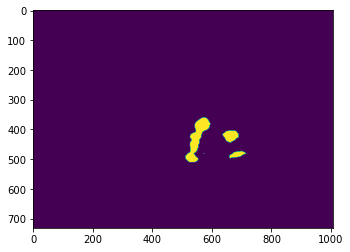

In [347]:
x=5
vid=6 #43,6 is interesting
plt.imshow(preds01[vid]["prediction"][:,:,x])

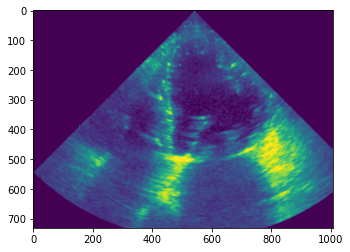

In [348]:
plt.imshow(testX[vid]["video"][:,:,x])

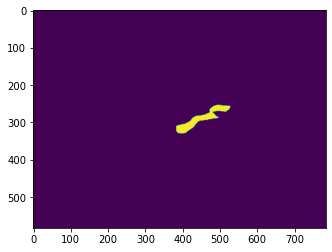

In [267]:
plt.imshow(preds40_01[vid]["prediction"][:,:,x])

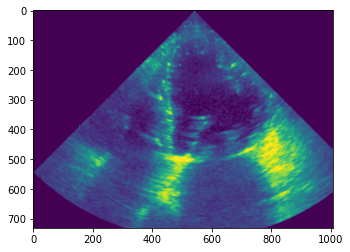

In [328]:
plt.imshow(testX[vid]["video"][:,:,5])

In [160]:
for j in range(20):
    nframes = prevpreds[j]["prediction"].shape[2]
    for k in range():

False

In [186]:
for i in range(587):
    print (prevpreds[vid]["prediction"][:,:,x][i,422])

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

In [351]:
vid=4
x=51
img = pres01[vid]["prediction"][:,:,x]
prev=False
now = False
for k in range(img.shape[1]):
    slice = img[:,k]
    if 1.0 not in slice and prev== True:
        print(f"WE GOT ONE in {k}")
        now = False
    #if prevpreds[vid]["prediction"][:,:,x][:,k].any():

    if 1.0 in slice:
        now = True
    prev = now

WE GOT ONE in 423
WE GOT ONE in 433
WE GOT ONE in 520
WE GOT ONE in 561
WE GOT ONE in 578
WE GOT ONE in 602


In [140]:
for i in range(20):
    nframes = prevpreds[i]["prediction"].shape[2]

84
78
53
104
73
159
72
63
90
62
94
68
51
63
125
65
54
106
39
69


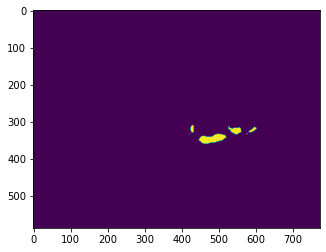

In [383]:
x=51
vid=4
plt.imshow(prevpreds[vid]["prediction"][:,:,x])

In [349]:
plt.imshow(testX[39]["video"][:,:,0])

IndexError: list index out of range

In [356]:
print(testX[0]["video"][:,int(testX[0]["video"].shape[1]/2),0])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0  32 159 166 155 152 154 158 144 148 149 164
 162 155 164 157 158 168 169 159 156 166 171 168 168 150 127 122 134 142
 143 145 131 123 113 116 129 133 130 133 128 124 130 139 143 142 133 119
 108 104 120 134 130 138 149 142 152 137 121 114 113 113 110 108 103  94
  96  98  85  72  70  71  76  75  73  70  64  64  74  87  90  99  92  82
  86  84  82  89 109 125 126 117 114 107  85  63  63  58  57  60  58  50
  39  33  37  38  41  40  29  18  19  28  32  29  22  23  29  26  22  24
  23  25  30  33  32  36  39  33  28  21  15  15  16  15  14  14  11  21
  30  31  28  25  23  22  23  35  33  26  30  27  24  31  28  35  36  32
  34  41  41  34  34  35  35  33  29  26  25  25  26  28  24  23  31  33
  32  34  35  33  28  23  27  39  50  55  33  27  27  28  20  16  17  15
  33  59  76  77  80  83  84  85  95  94  83  68  73 105 142 164 164 171
 174 167 162 164 168 169 171 161 169 169 172 182 18

In [369]:
print(test_dataset[0][0,int(test_dataset[0].shape[1]/2),:])

(3, 512, 512)
(3, 512, 512)
[-2.117904   -2.117904   -2.117904   -2.117904   -2.117904   -2.117904
 -2.117904   -2.117904   -2.117904   -2.117904   -2.117904   -2.117904
 -2.117904   -2.117904   -2.117904   -2.117904   -2.117904   -2.117904
 -2.117904   -2.117904   -2.117904   -2.117904   -2.117904   -2.117904
 -2.117904   -2.117904   -2.117904   -2.117904   -2.117904   -2.117904
 -2.117904   -2.117904   -2.117904   -2.117904   -2.117904   -2.117904
 -2.117904   -2.117904   -2.117904   -2.117904   -2.117904   -2.117904
 -2.117904   -2.117904   -2.117904   -2.117904   -2.117904   -2.117904
 -2.117904   -2.117904   -2.117904   -2.117904   -2.117904   -2.117904
 -2.117904   -2.117904   -2.117904   -2.117904   -2.117904   -2.117904
 -2.117904   -2.117904   -2.117904   -2.117904   -2.117904   -2.117904
 -2.117904   -2.117904   -2.117904   -2.117904   -2.117904   -2.117904
 -2.117904   -2.117904   -2.117904   -2.117904   -2.117904   -2.117904
 -2.117904   -2.117904   -2.117904   -2.117904   

In [15]:
with gzip.open("192epochsfpn_se_resnext50_32x4dfullds.pkl", 'rb') as f:
    predsdef = pickle.load(f)

In [17]:
preds = predsdef.copy()

In [18]:
preds[16]["prediction"].shape

(730, 772, 54)

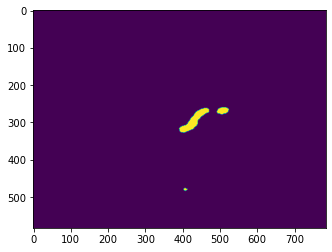

In [19]:
plt.imshow(preds[5]["prediction"][:,:,0])

In [20]:
for i in range(20):
    shapecur = preds[i]["prediction"].shape
    n_frames = preds[i]["prediction"].shape[2]
    newind = int(shapecur[1]*0.4)
    for j in range(n_frames):
        print(f"NEW FRAME {j}")
        preds[i]["prediction"][:,:newind,j] = 0.0
        frame = preds[i]["prediction"][:,:,j] 
        if frame.any():
            horizs = np.sort(np.nonzero(frame)[1])
            verts = np.sort(np.nonzero(frame)[0])
#             print(verts)
#             print(horizs)
            idxh = np.argmax(np.diff(horizs))
            idxv = np.argmax(np.diff(verts))
            hthres = horizs[idxh]
            vthres = verts[idxv]
            print(vthres)
            print(hthres)
            if np.max(np.diff(horizs))>60:
                print(f"not skipped h for {j}")
                if hthres<0.5*shapecur[1]:
                    hthres =  horizs[idxh+1]
                    preds[i]["prediction"][:,:hthres,j] = 0.0
                else:
                    hthres = horizs[idxh]
                    preds[i]["prediction"][:,hthres:,j] = 0.0
            if np.max(np.diff(verts))>60:
                print(f"not skipped v for {j}")
                if vthres<0.5*shapecur[0]:
                    vthres = verts[idxv+1]
                    preds[i]["prediction"][:vthres,:,j] = 0.0
                else:
                    vthres = verts[idxv]
                    preds[i]["prediction"][vthres:,:,j] = 0.0

NEW FRAME 0
NEW FRAME 1
303
499
NEW FRAME 2
294
499
NEW FRAME 3
NEW FRAME 4
373
490
NEW FRAME 5
376
482
NEW FRAME 6
379
484
NEW FRAME 7
NEW FRAME 8
380
493
NEW FRAME 9
390
505
NEW FRAME 10
NEW FRAME 11
376
487
NEW FRAME 12
371
541
NEW FRAME 13
366
518
NEW FRAME 14
364
493
NEW FRAME 15
367
544
NEW FRAME 16
361
533
NEW FRAME 17
361
479
NEW FRAME 18
354
475
NEW FRAME 19
321
505
NEW FRAME 20
NEW FRAME 21
NEW FRAME 22
NEW FRAME 23
NEW FRAME 24
NEW FRAME 25
NEW FRAME 26
NEW FRAME 27
NEW FRAME 28
NEW FRAME 29
284
494
NEW FRAME 30
NEW FRAME 31
NEW FRAME 32
NEW FRAME 33
309
503
NEW FRAME 34
320
518
NEW FRAME 35
286
508
NEW FRAME 36
NEW FRAME 37
NEW FRAME 38
NEW FRAME 39
NEW FRAME 40
NEW FRAME 41
NEW FRAME 42
NEW FRAME 43
NEW FRAME 44
328
535
NEW FRAME 45
332
491
NEW FRAME 46
364
492
NEW FRAME 47
339
541
NEW FRAME 48
368
483
NEW FRAME 49
NEW FRAME 50
374
480
NEW FRAME 51
NEW FRAME 52
NEW FRAME 53
NEW FRAME 54
NEW FRAME 55
NEW FRAME 56
368
468
NEW FRAME 57
368
497
NEW FRAME 58
373
536
NEW FRAME 5

NEW FRAME 2
257
484
NEW FRAME 3
257
487
NEW FRAME 4
257
491
NEW FRAME 5
279
479
NEW FRAME 6
276
386
NEW FRAME 7
266
378
NEW FRAME 8
272
379
NEW FRAME 9
270
380
NEW FRAME 10
267
483
NEW FRAME 11
274
522
NEW FRAME 12
261
375
NEW FRAME 13
267
501
NEW FRAME 14
244
374
NEW FRAME 15
268
365
NEW FRAME 16
243
369
NEW FRAME 17
252
370
NEW FRAME 18
262
372
NEW FRAME 19
251
479
NEW FRAME 20
255
462
NEW FRAME 21
240
446
NEW FRAME 22
239
444
NEW FRAME 23
240
449
NEW FRAME 24
235
459
NEW FRAME 25
249
450
NEW FRAME 26
248
458
NEW FRAME 27
251
465
NEW FRAME 28
250
462
NEW FRAME 29
250
383
NEW FRAME 30
254
384
NEW FRAME 31
270
382
NEW FRAME 32
273
379
NEW FRAME 33
257
378
NEW FRAME 34
269
381
NEW FRAME 35
254
375
NEW FRAME 36
256
373
NEW FRAME 37
258
377
NEW FRAME 38
257
375
NEW FRAME 39
250
374
NEW FRAME 40
242
377
NEW FRAME 41
258
482
NEW FRAME 42
256
375
NEW FRAME 43
262
374
NEW FRAME 44
248
375
NEW FRAME 45
247
375
NEW FRAME 46
248
375
NEW FRAME 47
238
372
NEW FRAME 48
234
440
NEW FRAME 49
241
438


NEW FRAME 62
202
466
not skipped h for 62
NEW FRAME 63
224
466
not skipped h for 63
NEW FRAME 64
197
468
not skipped h for 64
NEW FRAME 65
205
474
not skipped h for 65
NEW FRAME 66
224
480
NEW FRAME 67
255
492
NEW FRAME 68
255
490
NEW FRAME 69
243
490
NEW FRAME 70
243
484
NEW FRAME 71
220
480
NEW FRAME 72
219
485
NEW FRAME 73
226
488
NEW FRAME 74
240
488
NEW FRAME 75
245
488
NEW FRAME 76
254
491
NEW FRAME 77
261
493
NEW FRAME 78
260
493
NEW FRAME 79
264
493
NEW FRAME 80
254
515
NEW FRAME 81
251
517
NEW FRAME 82
249
488
NEW FRAME 83
239
485
NEW FRAME 84
240
485
NEW FRAME 85
252
488
NEW FRAME 86
261
493
NEW FRAME 87
253
490
NEW FRAME 88
258
490
NEW FRAME 89
255
488
NEW FRAME 0
301
537
NEW FRAME 1
224
525
NEW FRAME 2
306
375
not skipped h for 2
NEW FRAME 3
276
371
not skipped h for 3
NEW FRAME 4
313
384
not skipped h for 4
NEW FRAME 5
315
453
NEW FRAME 6
271
455
NEW FRAME 7
271
455
NEW FRAME 8
302
488
NEW FRAME 9
300
495
NEW FRAME 10
260
453
NEW FRAME 11
293
456
NEW FRAME 12
291
494
NEW F

298
391
NEW FRAME 4
299
391
NEW FRAME 5
300
385
NEW FRAME 6
299
379
NEW FRAME 7
299
383
NEW FRAME 8
301
387
NEW FRAME 9
299
392
NEW FRAME 10
295
386
NEW FRAME 11
294
386
NEW FRAME 12
288
383
NEW FRAME 13
285
381
NEW FRAME 14
283
373
NEW FRAME 15
286
383
NEW FRAME 16
282
380
NEW FRAME 17
281
498
NEW FRAME 18
282
380
NEW FRAME 19
209
379
not skipped v for 19
NEW FRAME 20
258
454
not skipped h for 20
NEW FRAME 21
259
445
NEW FRAME 22
258
462
NEW FRAME 23
266
471
NEW FRAME 24
268
474
NEW FRAME 25
274
380
NEW FRAME 26
282
530
NEW FRAME 27
280
382
NEW FRAME 28
284
472
NEW FRAME 29
288
468
NEW FRAME 30
279
466
NEW FRAME 31
278
464
NEW FRAME 32
274
469
NEW FRAME 33
292
477
NEW FRAME 34
303
390
NEW FRAME 35
301
398
NEW FRAME 36
303
391
NEW FRAME 37
302
387
NEW FRAME 38
301
378
NEW FRAME 39
303
383
NEW FRAME 40
298
381
NEW FRAME 41
294
392
NEW FRAME 42
290
391
NEW FRAME 43
288
390
NEW FRAME 44
281
381
NEW FRAME 45
279
382
NEW FRAME 46
282
378
NEW FRAME 47
281
379
NEW FRAME 48
280
381
NEW FRAME 4

303
382
not skipped h for 19
NEW FRAME 20
299
385
NEW FRAME 21
296
383
NEW FRAME 22
306
380
NEW FRAME 23
304
385
NEW FRAME 24
317
385
NEW FRAME 25
319
395
NEW FRAME 26
317
331
NEW FRAME 27
328
385
NEW FRAME 28
315
332
NEW FRAME 29
326
395
NEW FRAME 30
330
394
NEW FRAME 31
319
395
NEW FRAME 32
322
390
NEW FRAME 33
322
386
NEW FRAME 34
325
385
NEW FRAME 35
336
390
NEW FRAME 36
339
397
NEW FRAME 37
351
323
NEW FRAME 38
337
326
NEW FRAME 39
346
439
NEW FRAME 40
339
325
NEW FRAME 41
344
429
NEW FRAME 42
344
428
NEW FRAME 43
337
416
NEW FRAME 44
334
410
NEW FRAME 45
340
414
NEW FRAME 46
330
416
NEW FRAME 47
334
412
NEW FRAME 48
330
406
NEW FRAME 49
335
330
NEW FRAME 50
328
407
NEW FRAME 51
326
407
NEW FRAME 52
319
342
NEW FRAME 53
306
345
NEW FRAME 54
344
346
NEW FRAME 55
316
384
NEW FRAME 56
320
384
NEW FRAME 57
298
379
NEW FRAME 58
308
376
not skipped h for 58
NEW FRAME 59
308
383
NEW FRAME 60
323
386
not skipped h for 60
NEW FRAME 61
327
392
NEW FRAME 62
323
395
NEW FRAME 63
325
397
NEW F

In [648]:
vidid = 18
#BOXES = []
for i in range(vidid,vidid+1):
    maxleft = 1000
    maxright = 0
    maxup = 1000
    maxdown = 0
    nframes = preds[i]["prediction"].shape[2]
    vid = preds[i]["prediction"]
    print(nframes)
    print(preds[i]["prediction"].shape)
    for j in range(nframes):
        if vid[:,:,j].any() and np.sum(vid[:,:,j])>400 :
            horizontal = np.nonzero(vid[:,:,j])[1]
            vertical = np.nonzero(vid[:,:,j])[0]
            left,right,up,down = np.amin(horizontal),np.amax(horizontal),np.amin(vertical),np.amax(vertical)
            if left<maxleft:
                maxleft = left
            if right>maxright:
                maxright = right
            if up<maxup:
                maxup = up
            if down>maxdown:
                maxdown = down
#             print(f"frame {j} has {left}")
#             print(f"frame {j} has {right}")
#             print(f"frame {j} has {up}")
#             print(f"frame {j} has {down}")
#         else:
#              print("skipped")
    print(f" the maxes are {maxleft}, {maxright}, {maxup}, {maxdown} ")
#    BOXES.append((maxleft,maxright,maxup,maxdown))

39
(707, 855, 39)
 the maxes are 434, 515, 354, 396 


434
515
354
396
entered
474.5
375.0
346.25
602.75
304.3
445.7


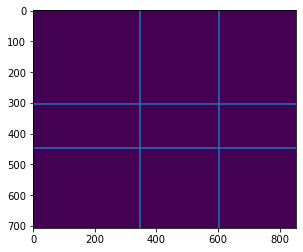

In [649]:
print(BOXES[vidid][0])
print(BOXES[vidid][1])
print(BOXES[vidid][2])
print(BOXES[vidid][3])

h = maxright-maxleft
v = maxdown-maxup
if 1.35*v>h:
    print("first boy")
    maxright += (1.35*v-h)/2
    maxleft -= (1.35*v-h)/2
if v>0.35*vid[:,:,0].shape[0]:
    #maxright -= 0.15*h
    maxleft += 0.15*h
    maxdown -= 0.25*v
    print("jhereee")
if v<0.15*vid[:,:,0].shape[0]:
    print("entered")
    mid = (maxright+maxleft)/2
    mid2 = (maxup+maxdown)/2
    print(mid)
    print(mid2)
    maxright += (mid+0.3*vid[:,:,0].shape[1]/2) - maxright
    maxleft -= maxleft - (mid-0.3*vid[:,:,0].shape[1]/2)
    maxup -= maxup - (mid2-0.2*vid[:,:,0].shape[0]/2)
    maxdown += (mid2+0.2*vid[:,:,0].shape[0]/2) - maxdown
plt.imshow(vid[:,:,10])
plt.axvline(x=maxleft)
plt.axvline(x=maxright)
plt.axhline(y=maxup)
plt.axhline(y=maxdown)
print(maxleft)
print(maxright)
print(maxup)
print(maxdown)

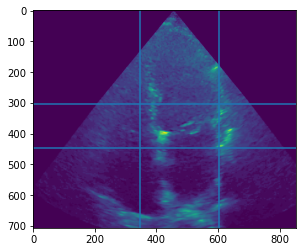

In [638]:
plt.imshow(testX[vidid]["video"][:,:,22])
plt.axvline(x=maxleft)
plt.axvline(x=maxright)
plt.axhline(y=maxup)
plt.axhline(y=maxdown)

In [650]:
maxleft

346.25

In [651]:
BOXES2[vidid][0]

346

In [652]:
maxup

304.3

In [653]:
BOXES2[vidid][2]

304

In [40]:
BOXES2

[(433, 604, 276, 402),
 (381, 542, 287, 406),
 (432, 601, 323, 432),
 (432, 601, 189, 287),
 (404, 629, 202, 369),
 (363, 555, 231, 336),
 (488, 758, 322, 522),
 (383, 544, 233, 321),
 (399, 611, 191, 348),
 (416, 599, 199, 334),
 (339, 576, 213, 363),
 (308, 476, 272, 396),
 (370, 573, 256, 407),
 (281, 494, 250, 408),
 (370, 583, 256, 386),
 (306, 461, 263, 378),
 (370, 546, 334, 453),
 (374, 530, 261, 348),
 (389, 560, 321, 428),
 (322, 493, 288, 414)]

16


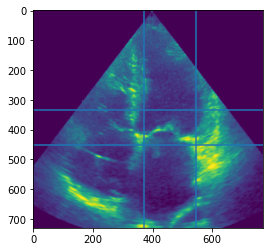

In [41]:
print(vidid)
plt.imshow(testX[vidid]["video"][:,:,10])
plt.axvline(x=BOXES2[vidid][0])
plt.axvline(x=BOXES2[vidid][1])
plt.axhline(y=BOXES2[vidid][2])
plt.axhline(y=BOXES2[vidid][3])

In [42]:
plt.imshow(preds4[vidid]["prediction"][:,:,10])

NameError: name 'preds4' is not defined

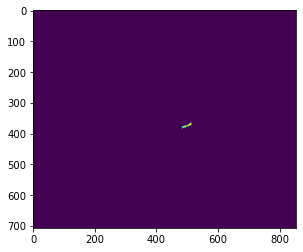

In [1937]:
avid = 18
aframe = 20
plt.imshow(preds4[avid]["prediction"][:,:,aframe])

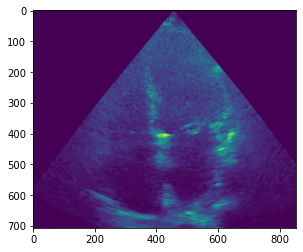

In [2517]:
plt.imshow(testX[avid]["video"][:,:,aframe])

In [719]:
with gzip.open("2nd_true2000_ensembled513and478.pkl", 'rb') as f:#gzip.open("boxed_top2000_thres=008_192epochsfpn_se_resnext50_32x4dfullds.pkl", 'rb') as f:
    preds3 = pickle.load(f)

In [2199]:
with gzip.open("192epochsfpn_se_resnext50_32x4dfullds.pkl", 'rb') as f:
    preds = pickle.load(f)

In [44]:
with gzip.open("resized_with_box_192epochsfpn_se_resnext50_32x4dfullds.pkl", 'rb') as f:
    preds4 = pickle.load(f)

In [45]:
with gzip.open("resized_with_box_171_epochsfpn_se_resnext50_32x4dfullds2.pkl", 'rb') as f:
    preds5 = pickle.load(f)

In [534]:
with gzip.open("9th_true=2000_ensembled513and478.pkl", 'rb') as f:
    preds6 = pickle.load(f)

In [698]:
with gzip.open("hopefullyimproved18.pkl", 'rb') as f:
    preds18 = pickle.load(f)

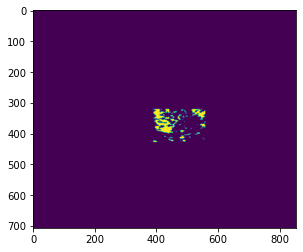

In [700]:
plt.imshow(preds6[18]["prediction"][:,:,30])

In [ ]:
count =0        
for i in range(20):
    maxleft,maxright,maxup,maxdown = BOXES2[i]
    print(BOXES2[i])
    n_frames = testX[i]["video"].shape[2]
    print(f"GOING INTO {i}th video")

    for j in range(n_frames):
            
        preds3[i]["prediction"][:,:,j] != preds6[i]["prediction"][:,:,j]:
            print(f"VID {i} FRAME {j}")
        count+=1

    predictions.append({
        'name': testX[i]['name'],
        'prediction': prediction
        }
    )

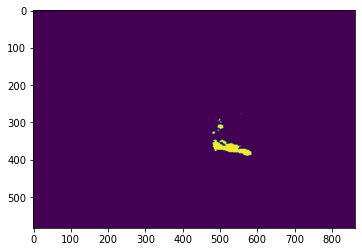

In [1886]:
plt.imshow(preds3[avid]["prediction"][:,:,frame])

In [1844]:
preds18[avid]["prediction"][:,:,frame].sum()

1591

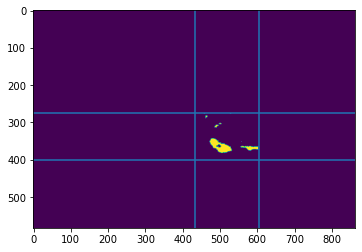

In [1845]:
plt.imshow(preds18[avid]["prediction"][:,:,frame])
plt.axvline(x=BOXES2[vido][0])
plt.axvline(x=BOXES2[vido][1])
plt.axhline(y=BOXES2[vido][2])
plt.axhline(y=BOXES2[vido][3])

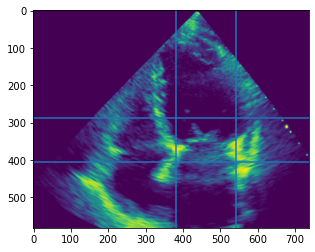

In [2073]:
plt.imshow(testX[avid]["video"][:,:,frame])
plt.axvline(x=BOXES2[vido][0])
plt.axvline(x=BOXES2[vido][1])
plt.axhline(y=BOXES2[vido][2])
plt.axhline(y=BOXES2[vido][3])

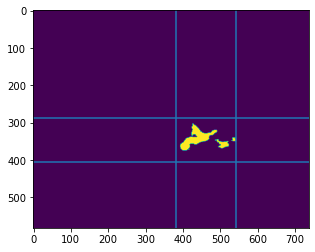

In [2074]:
avid = 1
vido = 1
frame = 15
plt.imshow(predictions[avid]["prediction"][:,:,frame])
plt.axvline(x=BOXES2[vido][0])
plt.axvline(x=BOXES2[vido][1])
plt.axhline(y=BOXES2[vido][2])
plt.axhline(y=BOXES2[vido][3])

In [1944]:
predictions[avid]["prediction"][:,:,frame].sum()

1850

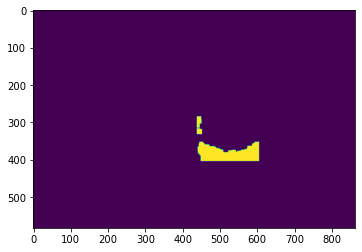

In [1675]:
plt.imshow(cv2.morphologyEx(predictions[avid]["prediction"][:,:,frame].astype(np.uint8), cv2.MORPH_OPEN, np.ones((8,8))))

In [1676]:
cv2.morphologyEx(predictions[avid]["prediction"][:,:,frame].astype(np.uint8), cv2.MORPH_OPEN, np.ones((8,8))).sum()

6568

In [254]:
testX[avid]["video"][BOXES2[vido][2]:BOXES2[vido][3],BOXES2[vido][0]:BOXES2[vido][1],frame-7].astype(int) - testX[avid]["video"][BOXES2[vido][2]:BOXES2[vido][3],BOXES2[vido][0]:BOXES2[vido][1],frame].astype(int)

array([[44, 36, 25, ..., 12,  5,  2],
       [49, 43, 31, ..., 12,  4, -2],
       [48, 42, 32, ...,  8, -1, -8],
       ...,
       [40, 41, 44, ...,  5,  5,  3],
       [44, 44, 48, ...,  2,  3,  0],
       [54, 57, 61, ...,  1,  1, -2]])

C:\Users\Marios\AppData\Local\Temp/ipykernel_31840/3259013936.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.imshow(cv2.morphologyEx(newboi.astype(np.uint8), cv2.MORPH_OPEN, kernel).round().astype(np.bool))


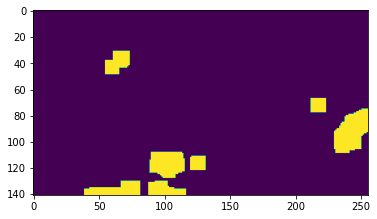

In [1526]:
plt.imshow(cv2.morphologyEx(newboi.astype(np.uint8), cv2.MORPH_OPEN, kernel).round().astype(np.bool))

C:\Users\Marios\AppData\Local\Temp/ipykernel_31840/2509398544.py:22: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  newboi = np.logical_or(newboi.astype(np.bool),preds18[i]["prediction"][BOXES2[i][2]:BOXES2[i][3],BOXES2[i][0]:BOXES2[i][1],j])


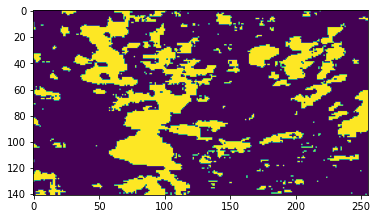

In [1543]:
kernel = np.ones((6,6),np.uint8)
i=18
j=0

best = testX[avid]["video"][BOXES2[vido][2]:BOXES2[vido][3],BOXES2[vido][0]:BOXES2[vido][1],6]

cur = testX[i]["video"][BOXES2[i][2]:BOXES2[i][3],BOXES2[i][0]:BOXES2[i][1],j]
temp = cur.astype(int)-best.astype(int)

temp = temp/255
more = temp>0.04
less = (-temp)>0.04
newboi = np.zeros_like(temp)


newboi[more] = 1
newboi[less] = 0
#newboi = cv2.morphologyEx(newboi.astype(np.uint8), cv2.MORPH_OPEN, kernel).round().astype(np.bool)

newboi[np.logical_and(~more,~less)] = preds3[i]["prediction"][BOXES2[i][2]:BOXES2[i][3],BOXES2[i][0]:BOXES2[i][1],6][np.logical_and(~more,~less)]

newboi = np.logical_or(newboi.astype(np.bool),preds18[i]["prediction"][BOXES2[i][2]:BOXES2[i][3],BOXES2[i][0]:BOXES2[i][1],j])
plt.imshow(newboi)

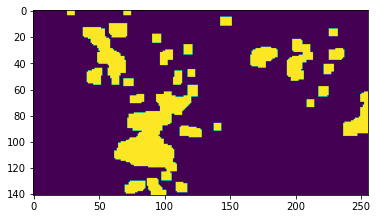

In [1544]:
plt.imshow(cv2.morphologyEx(newboi.astype(np.uint8), cv2.MORPH_OPEN, kernel))

In [1553]:
np.sum(cv2.morphologyEx(newboi.astype(np.uint8), cv2.MORPH_OPEN, kernel))

5989

In [113]:
np.sum(magnitude[BOXES2[avid][2]:BOXES2[avid][3],BOXES2[avid][0]:BOXES2[avid][1]])

131109.23

In [ ]:
testX[avid]["video"][:,:,frame-7][BOXES2[avid][2]:BOXES2[avid][3],BOXES2[avid][0]:BOXES2[avid][1]]

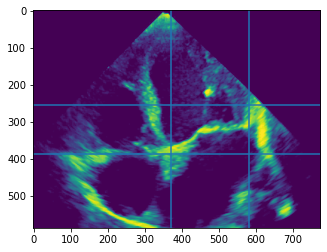

In [382]:
plt.imshow(testX[avid]["video"][:,:,frame])
plt.axvline(x=BOXES2[vido][0])
plt.axvline(x=BOXES2[vido][1])
plt.axhline(y=BOXES2[vido][2])
plt.axhline(y=BOXES2[vido][3])

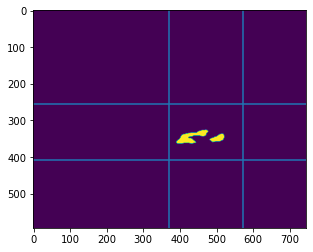

In [409]:
avid = 12
vido = 12
frame = 37
plt.imshow(preds3[avid]["prediction"][:,:,frame])
plt.axvline(x=BOXES2[vido][0])
plt.axvline(x=BOXES2[vido][1])
plt.axhline(y=BOXES2[vido][2])
plt.axhline(y=BOXES2[vido][3])

In [417]:
MAXFRAMES = []
RATIOS  = []
for i in range(20):
    nf = preds3[i]["prediction"].shape[2]
    shapecur = preds3[i]["prediction"].shape
    count=0
    badones = []
    maxb = 0
    minb = 10000
    maxidx = 0
    minidx = 0
    for j in range(nf):
        if np.sum(preds3[i]["prediction"][:,:,j])<2000:
            count+=1
            badones.append(j)
        if np.sum(preds3[i]["prediction"][:,:,j])>maxb:
            maxidx = j
            maxb = np.sum(preds3[i]["prediction"][:,:,j])
        if np.sum(preds3[i]["prediction"][:,:,j])<minb:
            minidx = j
            minb = np.sum(preds3[i]["prediction"][:,:,j])
    MAXFRAMES.append(maxidx)
    RATIOS.append(count/nf)
    print(f"VIDEO {i} has shape {shapecur} and {count}/{nf} (ratio: {RATIOS[i]}) frames that will change {badones} max is {maxidx} with {maxb} min is {minidx} with {minb}")

VIDEO 0 has shape (583, 863, 84) and 26/84 (ratio: 0.30952380952380953) frames that will change [5, 7, 8, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 48, 51, 52, 67, 68, 69, 70, 71, 75, 79, 83] max is 64 with 4031 min is 71 with 293
VIDEO 1 has shape (582, 737, 78) and 1/78 (ratio: 0.01282051282051282) frames that will change [20] max is 25 with 3448 min is 20 with 1732
VIDEO 2 has shape (732, 845, 53) and 4/53 (ratio: 0.07547169811320754) frames that will change [20, 21, 41, 45] max is 6 with 3627 min is 21 with 1386
VIDEO 3 has shape (587, 781, 104) and 33/104 (ratio: 0.3173076923076923) frames that will change [0, 1, 16, 17, 18, 19, 20, 21, 22, 23, 24, 27, 28, 29, 30, 32, 34, 52, 53, 54, 55, 56, 57, 60, 61, 65, 66, 67, 70, 91, 93, 96, 99] max is 2 with 2999 min is 55 with 561
VIDEO 4 has shape (587, 773, 73) and 0/73 (ratio: 0.0) frames that will change [] max is 17 with 6605 min is 36 with 2088
VIDEO 5 has shape (583, 784, 159) and 0/159 (ratio: 0.0) frames that will change [] 

In [1873]:
(preds3[4]["prediction"][:,:,51] ==  predictions[4]["prediction"][:,:,51]).all()

True

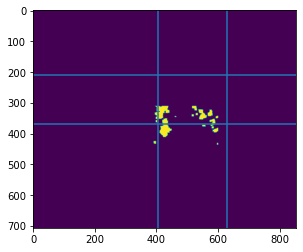

In [1878]:
plt.imshow(predictions[18]["prediction"][:,:,15])
plt.axvline(x=BOXES2[4][0])
plt.axvline(x=BOXES2[4][1])
plt.axhline(y=BOXES2[4][2]+7)
plt.axhline(y=BOXES2[4][3])

(433, 604, 276, 402)
GOING INTO 0th video
0 7 enter with 1531
0 8 enter with 1593


C:\Users\Marios\AppData\Local\Temp/ipykernel_31840/1361102592.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  prediction = np.array(np.zeros_like(testX[i]["video"]), dtype=np.bool)
C:\Users\Marios\AppData\Local\Temp/ipykernel_31840/1361102592.py:37: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  prediction[BOXES2[i][2]:BOXES2[i][3],BOXES2[i][0]

0 23 enter with 897
Im in here for vid 0 and frame 23 and my sum is 12731


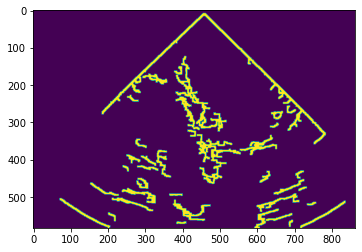

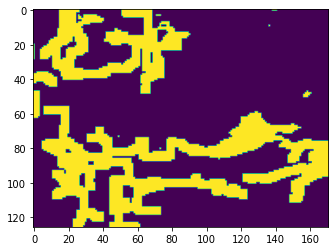

0 24 enter with 1250
Im in here for vid 0 and frame 24 and my sum is 11643


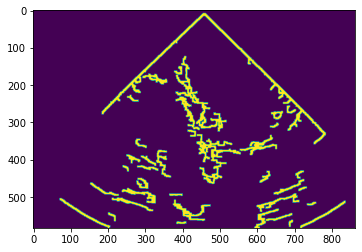

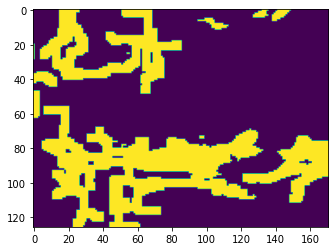

0 25 enter with 1386
Im in here for vid 0 and frame 25 and my sum is 10605


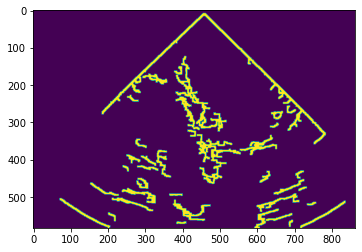

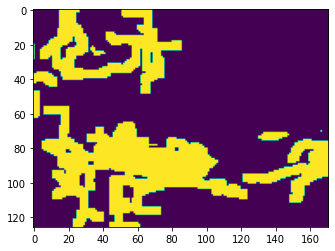

0 27 enter with 1559
Im in here for vid 0 and frame 27 and my sum is 10628


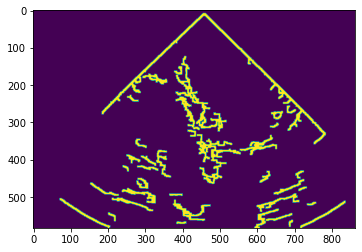

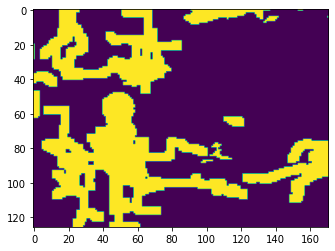

0 28 enter with 954
Im in here for vid 0 and frame 28 and my sum is 9621


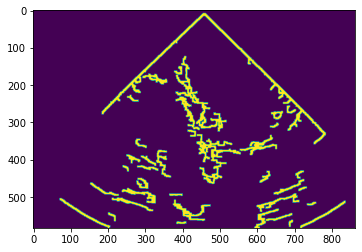

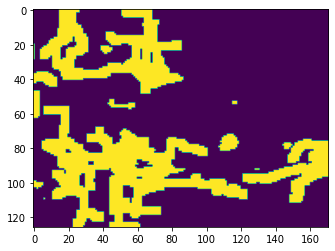

0 29 enter with 1048
Im in here for vid 0 and frame 29 and my sum is 10053


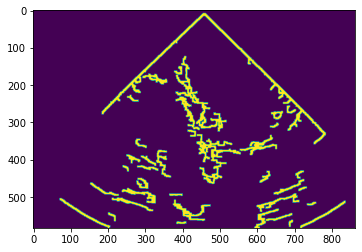

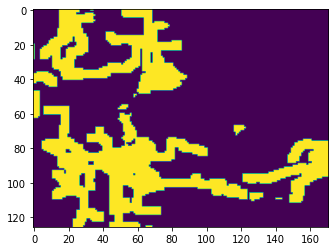

0 30 enter with 929
Im in here for vid 0 and frame 30 and my sum is 9689


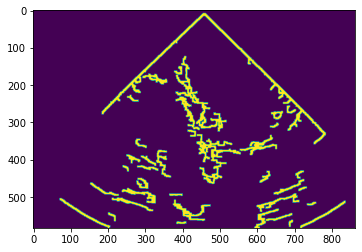

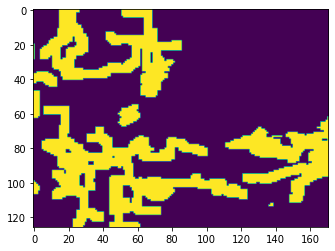

0 32 enter with 1105
Im in here for vid 0 and frame 32 and my sum is 9982


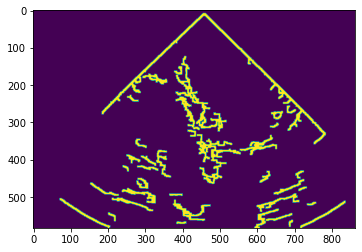

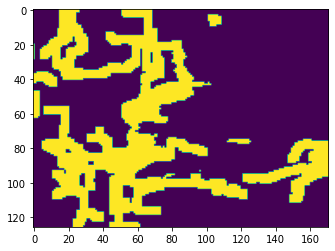

0 48 enter with 1300
0 51 enter with 1570
0 52 enter with 1527
0 69 enter with 961
Im in here for vid 0 and frame 69 and my sum is 12515


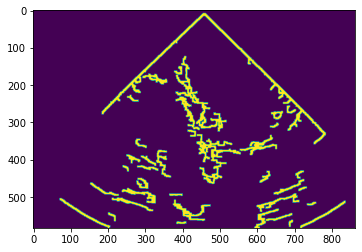

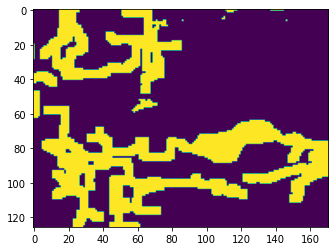

0 70 enter with 1062
Im in here for vid 0 and frame 70 and my sum is 11709


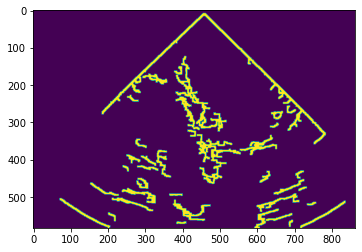

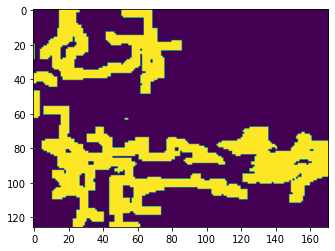

0 71 enter with 293
Im in here for vid 0 and frame 71 and my sum is 10785


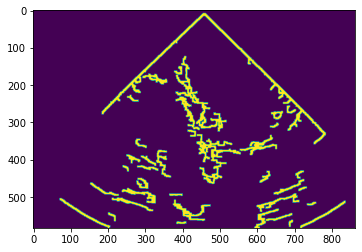

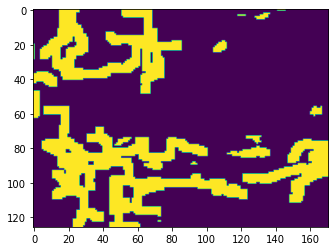

(381, 542, 287, 406)
GOING INTO 1th video
(388, 645, 307, 448)
GOING INTO 2th video
(432, 601, 189, 287)
GOING INTO 3th video
3 0 enter with 1303
3 1 enter with 1593


C:\Users\Marios\AppData\Local\Temp/ipykernel_31840/1361102592.py:39: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  prediction[BOXES2[i][2]:BOXES2[i][3],BOXES2[i][0]:BOXES2[i][1],j] = np.logical_or(newboi.astype(np.bool),preds18[i]["prediction"][BOXES2[i][2]:BOXES2[i][3],BOXES2[i][0]:BOXES2[i][1],j])


3 17 enter with 1478
3 18 enter with 1482
3 19 enter with 1484
3 20 enter with 1172
3 21 enter with 725
3 22 enter with 1489
3 23 enter with 1544
3 29 enter with 1558
3 30 enter with 1388
3 53 enter with 1217
3 54 enter with 1229
3 55 enter with 561
3 56 enter with 1111
3 60 enter with 1488
3 61 enter with 1530
(404, 629, 202, 369)
GOING INTO 4th video
(363, 555, 231, 336)
GOING INTO 5th video
(488, 758, 322, 522)
GOING INTO 6th video
(383, 544, 233, 321)
GOING INTO 7th video
7 19 enter with 1576
7 20 enter with 1005
7 21 enter with 1118
7 22 enter with 1090
7 54 enter with 983
7 55 enter with 936
7 56 enter with 1140
7 57 enter with 1587
(399, 611, 191, 348)
GOING INTO 8th video
(416, 599, 199, 334)
GOING INTO 9th video
(339, 576, 213, 363)
GOING INTO 10th video
(308, 476, 272, 396)
GOING INTO 11th video
11 15 enter with 1525
11 18 enter with 1286
11 19 enter with 1577
(370, 573, 256, 407)
GOING INTO 12th video
(281, 494, 250, 408)
GOING INTO 13th video
(370, 583, 256, 386)
GOING INTO

In [1883]:
count =0        
predictions = []
kernel = np.ones((10,10),np.uint8)
kernel2 = np.ones((6,6),np.uint8)
kernel3 = np.ones((8,8),np.uint8)
kernel4 = np.ones((5,5),np.uint8)

for i in range(20):
    print(BOXES2[i])
    n_frames = testX[i]["video"].shape[2]
    prediction = np.array(np.zeros_like(testX[i]["video"]), dtype=np.bool)
    print(f"GOING INTO {i}th video")
    
    if RATIOS[i]>0.1:
        maxfridx = MAXFRAMES[i]
        best = testX[i]["video"][BOXES2[i][2]:BOXES2[i][3],BOXES2[i][0]:BOXES2[i][1],maxfridx]
        
        for j in range(n_frames):
            if np.sum(preds3[i]["prediction"][:,:,j])<1600 and np.sum(preds18[i]["prediction"][:,:,j])<2100 :
                print(f"{i} {j} enter with {np.sum(preds3[i]['prediction'][:,:,j])}")

                cur = testX[i]["video"][BOXES2[i][2]:BOXES2[i][3],BOXES2[i][0]:BOXES2[i][1],j]
                temp = cur.astype(int)-best.astype(int)

                temp = temp/255
                more = temp>0.04
                less = (-temp)>0.04
                newboi = np.zeros_like(temp)
                
                newboi[more] = 1
                newboi[less] = 0
                newboi[np.logical_and(~more,~less)] = preds3[i]["prediction"][BOXES2[i][2]:BOXES2[i][3],BOXES2[i][0]:BOXES2[i][1],maxfridx][np.logical_and(~more,~less)]
                
                if newboi.sum()>5500:
                    newboi = cv2.morphologyEx(newboi.astype(np.uint8), cv2.MORPH_OPEN, kernel2)
                if newboi.sum()>5500:
                    prediction[BOXES2[i][2]:BOXES2[i][3],BOXES2[i][0]:BOXES2[i][1],j] = cv2.morphologyEx(np.logical_or(newboi.astype(np.bool),preds18[i]["prediction"][BOXES2[i][2]:BOXES2[i][3],BOXES2[i][0]:BOXES2[i][1],j]).astype(np.uint8), cv2.MORPH_OPEN, kernel3).astype(np.bool) #opening
                else:
                    prediction[BOXES2[i][2]:BOXES2[i][3],BOXES2[i][0]:BOXES2[i][1],j] = np.logical_or(newboi.astype(np.bool),preds18[i]["prediction"][BOXES2[i][2]:BOXES2[i][3],BOXES2[i][0]:BOXES2[i][1],j])
                if newboi.sum()>5500:
                    prediction[:,:,j] = cv2.morphologyEx(prediction[:,:,j].astype(np.uint8), cv2.MORPH_OPEN, kernel)
                prediction[:,:,j] = np.logical_or(preds3[i]["prediction"][:,:,j],prediction[:,:,j])
                if newboi.sum()>3000 and testX[i]["video"].shape[0]<600 :
                    prediction[:,:,j] = cv2.morphologyEx(prediction[:,:,j].astype(np.uint8), cv2.MORPH_OPEN, kernel4)
                
                
                if np.sum(prediction[:,:,j])>8000:
                    print(f"Im in here for vid {i} and frame {j} and my sum is {np.sum(prediction[:,:,j])}")
                    prediction[:,:,j] = False
                    prediction[:,:,j] = np.logical_or(preds3[i]["prediction"][:,:,j],preds18[i]["prediction"][:,:,j])
                    
                    newboi = (cv2.Canny(cv2.erode(testX[avid]["video"][:,:,i], kernel, iterations=1),70,200))
                    newboi = cv2.dilate(newboi.astype(np.uint8), np.ones((5,5)), iterations=1)
                    plt.imshow(newboi)
                    plt.show()

                    prediction[BOXES2[i][2]:BOXES2[i][3],BOXES2[i][0]:BOXES2[i][1],j] = np.logical_or(newboi[BOXES2[i][2]:BOXES2[i][3],BOXES2[i][0]:BOXES2[i][1]],prediction[BOXES2[i][2]:BOXES2[i][3],BOXES2[i][0]:BOXES2[i][1],j])
                    plt.imshow(prediction[BOXES2[i][2]:BOXES2[i][3],BOXES2[i][0]:BOXES2[i][1],j])
                    plt.show()
                    
                prediction[:(BOXES2[i][2]+7),:,j] = 0.0
                prediction[:,:(BOXES2[i][0]+5),j] = 0.0


            else:
                prediction[:,:,j] = preds3[i]["prediction"][:,:,j]
                if prediction[:,:,j].sum()<2500:
                    prediction[:,:,j] = np.logical_or(preds3[i]["prediction"][:,:,j],preds18[i]["prediction"][:,:,j])
            count+=1
    else:
        for j in range(n_frames):
            prediction[:,:,j] = preds3[i]["prediction"][:,:,j]

    predictions.append({
        'name': testX[i]['name'],
        'prediction': prediction
        }
    )

In [283]:
i = 0 
maxsum = 0
for pos in range(preds3[avid]["prediction"].shape[2]):
    print(preds3[avid]["prediction"][:,:,pos].sum())
    if preds3[avid]["prediction"][:,:,pos].sum()>maxsum:
        maxsum = preds3[avid]["prediction"][:,:,pos].sum()
        i = pos

807
653
536
803
734
1012
2159
1766
1757
1035
928
587
502
478
73
231
1343
923
1244
1253
1141
1953
2103
815
909
670
572
928
57
396
836
1225
887
1129
1053
333
313
507
939


----------------------------------------START OF ANISOTROPIC BS----------------------------------------------------

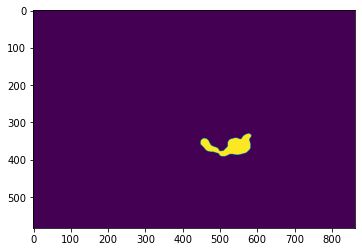

In [2393]:
plt.imshow(np.where(anisodiff(preds3[avid]["prediction"][:,:,frame],100,5,0.1,(1,1),2.5,2)>0.3,1,0))

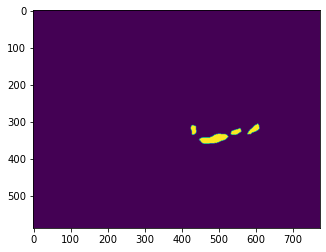

In [2338]:
plt.imshow(preds[avid]["prediction"][:,:,frame])

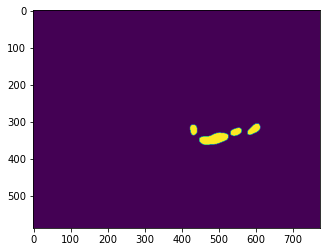

In [2339]:
plt.imshow(predictions[avid]["prediction"][:,:,frame])

In [643]:
BOXES2 = []
for i in range(len(testX)):
    video = testX[i]["video"]
    maxleft,maxright,maxup,maxdown = BOXES[i][0],BOXES[i][1],BOXES[i][2],BOXES[i][3]
    print(f"before is {i} {maxleft} {maxright} {maxup} {maxdown}")
    h = maxright-maxleft
    v = maxdown-maxup
    if 1.35*v>h:
        print("first boy")
        maxright += (1.35*v-h)/2
        maxleft -= (1.35*v-h)/2
    if v>0.35*video[:,:,0].shape[0]:
        maxright -= 0.15*h
        maxleft += 0.15*h
        maxdown -= 0.25*v
        print("jhereee")
    if v<0.15*video[:,:,0].shape[0]:
        print("entered")
        mid = (maxright+maxleft)/2
        mid2 = (maxup+maxdown)/2
        print(mid)
        print(mid2)
        maxright += (mid+0.3*vid[:,:,0].shape[1]/2) - maxright
        maxleft -= maxleft - (mid-0.3*vid[:,:,0].shape[1]/2)
        maxup -= maxup - (mid2-0.2*vid[:,:,0].shape[0]/2)
        maxdown += (mid2+0.2*vid[:,:,0].shape[0]/2) - maxdown
    
    print(f"maxright is {maxright}")
    print(f"maxleft is {maxleft}")
    print(f"maxup is {maxup}")
    print(f"maxdown is {maxdown}")
    BOXES2.append((int(maxleft),int(maxright),int(maxup),int(maxdown)))

before is 0 475 563 276 402
first boy
maxright is 604.05
maxleft is 433.95
maxup is 276
maxdown is 402
before is 1 384 540 287 406
first boy
maxright is 542.325
maxleft is 381.675
maxup is 287
maxdown is 406
before is 2 433 601 329 427
entered
517.0
378.0
maxright is 645.25
maxleft is 388.75
maxup is 307.3
maxdown is 448.7
before is 3 432 601 189 287
maxright is 601
maxleft is 432
maxup is 189
maxdown is 287
before is 4 416 618 202 369
first boy
maxright is 629.725
maxleft is 404.275
maxup is 202
maxdown is 369
before is 5 363 555 231 336
maxright is 555
maxleft is 363
maxup is 231
maxdown is 336
before is 6 489 758 322 522
first boy
maxright is 758.5
maxleft is 488.5
maxup is 322
maxdown is 522
before is 7 383 544 233 321
maxright is 544
maxleft is 383
maxup is 233
maxdown is 321
before is 8 411 600 191 348
first boy
maxright is 611.475
maxleft is 399.525
maxup is 191
maxdown is 348
before is 9 452 564 199 334
first boy
maxright is 599.125
maxleft is 416.875
maxup is 199
maxdown is 33

In [2314]:
count =0        
predictions = []
kernel = np.ones((5,5),np.uint8)
for i in range(20):
    maxleft,maxright,maxup,maxdown = BOXES2[i]
    print(BOXES2[i])
    n_frames = testX[i]["video"].shape[2]
    prediction = np.array(np.zeros_like(testX[i]["video"]), dtype=np.bool)
    print(f"GOING INTO {i}th video")

    for j in range(n_frames):
#         if np.sum(preds[i]["prediction"][:,:,j])<=2000:
#             print(f"{i} {j} enter with {np.sum(preds[i]['prediction'][:,:,j])}")
#             prediction[:,:,j] = np.logical_or(preds6[i]["prediction"][:,:,j],preds5[i]["prediction"][:,:,j],preds4[i]["prediction"][:,:,j])
#             print(f"now is {np.sum(prediction[:,:,j])}")
#         else:
#           prediction[:,:,j] = preds[i]["prediction"][:,:,j] 
        if np.sum(preds[i]["prediction"][:,:,j])<=2000:
            print(f"{i} {j} enter with {np.sum(preds[i]['prediction'][:,:,j])}")
            prediction[:,:,j] = np.logical_or(preds5[i]["prediction"][:,:,j],preds4[i]["prediction"][:,:,j])
        else:
            prediction[:,:,j] = preds[i]["prediction"][:,:,j] #preds[i]["prediction"][:,:,j]
        prediction[:,:,j][:,:maxleft] = 0.0
        prediction[:,:,j][:,maxright:] = 0.0
        prediction[:,:,j][:maxup,:] = 0.0
        prediction[:,:,j][maxdown:,:] = 0.0
        prediction[:,:,j] = np.where(anisodiff(prediction[:,:,j],100,5,0.1,(1,1),2.5,2)> 0.25, 1, 0) #anisotropic diffusion
        prediction[:,:,j] = cv2.morphologyEx(prediction[:,:,j].astype(np.uint8), cv2.MORPH_OPEN, kernel).astype(np.bool) #opening
        
        count+=1

    predictions.append({
        'name': testX[i]['name'],
        'prediction': prediction
        }
    )
    

(433, 604, 276, 402)
GOING INTO 0th video
0 0 enter with 0


C:\Users\Marios\AppData\Local\Temp/ipykernel_3224/3858416764.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  prediction = np.array(np.zeros_like(testX[i]["video"]), dtype=np.bool)
C:\Users\Marios\AppData\Local\Temp/ipykernel_3224/3858416764.py:28: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  prediction[:,:,j] = cv2.morphologyEx(prediction[:,:,

0 1 enter with 245
0 2 enter with 823
0 3 enter with 0
0 4 enter with 21
0 5 enter with 143
0 6 enter with 606
0 7 enter with 0
0 8 enter with 308
0 9 enter with 20
0 10 enter with 0
0 11 enter with 504
0 12 enter with 95
0 13 enter with 583
0 14 enter with 780
0 15 enter with 8
0 16 enter with 183
0 17 enter with 707
0 18 enter with 633
0 19 enter with 61
0 20 enter with 0
0 21 enter with 0
0 22 enter with 0
0 23 enter with 0
0 24 enter with 0
0 25 enter with 0
0 26 enter with 0
0 27 enter with 0
0 28 enter with 0
0 29 enter with 384
0 30 enter with 0
0 31 enter with 0
0 32 enter with 0
0 33 enter with 392
0 34 enter with 36
0 35 enter with 534
0 36 enter with 0
0 37 enter with 0
0 38 enter with 0
0 39 enter with 0
0 40 enter with 0
0 41 enter with 0
0 42 enter with 0
0 43 enter with 0
0 44 enter with 46
0 45 enter with 14
0 46 enter with 965
0 47 enter with 52
0 48 enter with 457
0 49 enter with 0
0 50 enter with 197
0 51 enter with 0
0 52 enter with 0
0 53 enter with 0
0 54 enter wi

15 15 enter with 1972
15 17 enter with 1992
(370, 546, 334, 453)
GOING INTO 16th video
16 35 enter with 1916
16 39 enter with 1919
(374, 530, 261, 348)
GOING INTO 17th video
17 0 enter with 697
17 1 enter with 1516
17 7 enter with 1305
17 9 enter with 791
17 10 enter with 598
17 11 enter with 539
17 12 enter with 187
17 13 enter with 545
17 14 enter with 879
17 15 enter with 493
17 16 enter with 640
17 17 enter with 277
17 18 enter with 237
17 19 enter with 1026
17 20 enter with 320
17 21 enter with 267
17 22 enter with 0
17 23 enter with 0
17 24 enter with 0
17 25 enter with 152
17 26 enter with 164
17 27 enter with 55
17 28 enter with 0
17 29 enter with 9
17 30 enter with 145
17 31 enter with 11
17 32 enter with 103
17 33 enter with 0
17 34 enter with 381
17 35 enter with 244
17 36 enter with 556
17 37 enter with 302
17 38 enter with 82
17 39 enter with 552
17 40 enter with 238
17 41 enter with 990
17 42 enter with 654
17 43 enter with 632
17 44 enter with 849
17 45 enter with 717
17

In [2223]:
import scipy.ndimage.filters as flt
def anisodiff(img,niter=1,kappa=50,gamma=0.1,step=(1.,1.),sigma=0, option=1,ploton=False):
    """
    Anisotropic diffusion.

    Usage:
    imgout = anisodiff(im, niter, kappa, gamma, option)

    Arguments:
            img    - input image
            niter  - number of iterations
            kappa  - conduction coefficient 20-100 ?
            gamma  - max value of .25 for stability
            step   - tuple, the distance between adjacent pixels in (y,x)
            option - 1 Perona Malik diffusion equation No 1
                     2 Perona Malik diffusion equation No 2
            ploton - if True, the image will be plotted on every iteration

    Returns:
            imgout   - diffused image.

    kappa controls conduction as a function of gradient.  If kappa is low
    small intensity gradients are able to block conduction and hence diffusion
    across step edges.  A large value reduces the influence of intensity
    gradients on conduction.

    gamma controls speed of diffusion (you usually want it at a maximum of
    0.25)

    step is used to scale the gradients in case the spacing between adjacent
    pixels differs in the x and y axes

    Diffusion equation 1 favours high contrast edges over low contrast ones.
    Diffusion equation 2 favours wide regions over smaller ones.
  """
  
    # ...you could always diffuse each color channel independently if you
    # really want
    if img.ndim == 3:
        warnings.warn("Only grayscale images allowed, converting to 2D matrix")
        img = img.mean(2)

    # initialize output array
    img = img.astype('float32')
    imgout = img.copy()

    # initialize some internal variables
    deltaS = np.zeros_like(imgout)
    deltaE = deltaS.copy()
    NS = deltaS.copy()
    EW = deltaS.copy()
    gS = np.ones_like(imgout)
    gE = gS.copy()

    # create the plot figure, if requested
    if ploton:
        import pylab as pl
        from time import sleep

        fig = pl.figure(figsize=(20,5.5),num="Anisotropic diffusion")
        ax1,ax2 = fig.add_subplot(1,2,1),fig.add_subplot(1,2,2)

        ax1.imshow(img,interpolation='nearest')
        ih = ax2.imshow(imgout,interpolation='nearest',animated=True)
        ax1.set_title("Original image")
        ax2.set_title("Iteration 0")

        fig.canvas.draw()

    for ii in np.arange(1,niter):

        # calculate the diffs
        deltaS[:-1,: ] = np.diff(imgout,axis=0)
        deltaE[: ,:-1] = np.diff(imgout,axis=1)

        if 0<sigma:
            deltaSf=flt.gaussian_filter(deltaS,sigma);
            deltaEf=flt.gaussian_filter(deltaE,sigma);
        else: 
            deltaSf=deltaS;
            deltaEf=deltaE;
            
        # conduction gradients (only need to compute one per dim!)
        if option == 1:
            gS = np.exp(-(deltaSf/kappa)**2.)/step[0]
            gE = np.exp(-(deltaEf/kappa)**2.)/step[1]
        elif option == 2:
            gS = 1./(1.+(deltaSf/kappa)**2.)/step[0]
            gE = 1./(1.+(deltaEf/kappa)**2.)/step[1]

        # update matrices
        E = gE*deltaE
        S = gS*deltaS

        # subtract a copy that has been shifted 'North/West' by one
        # pixel. don't as questions. just do it. trust me.
        NS[:] = S
        EW[:] = E
        NS[1:,:] -= S[:-1,:]
        EW[:,1:] -= E[:,:-1]

        # update the image
        imgout += gamma*(NS+EW)

        if ploton:
            iterstring = "Iteration %i" %(ii+1)
            ih.set_data(imgout)
            ax2.set_title(iterstring)
            fig.canvas.draw()
            # sleep(0.01)

    return imgout

In [2284]:
kernel = np.ones((5,5),np.uint8)
opening = cv2.morphologyEx(predictions[avid]["prediction"][:,:,frame].astype(np.uint8), cv2.MORPH_OPEN, kernel)
closing = cv2.morphologyEx(np.where(newad > 0.2, 1, 0).astype(np.uint8), cv2.MORPH_CLOSE, kernel)

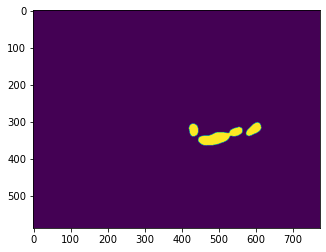

In [2285]:
plt.imshow(np.where(closing > 0.1, 1, 0))

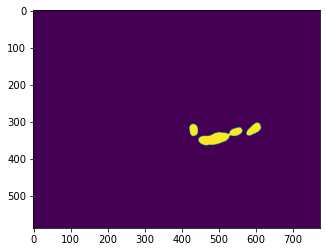

In [2311]:
newad = anisodiff(predictions[4]["prediction"][:,:,50],100,5,0.1,(1,1),2.5,2)
plt.imshow(np.where(newad > 0.25, 1, 0))

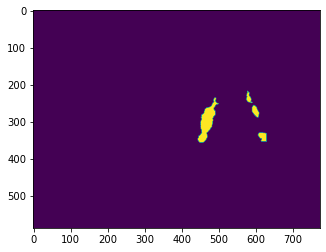

In [2296]:
plt.imshow(predictions[avid]["prediction"][:,:,frame-25])

In [533]:
with gzip.open('11th_true=2000_ensembled513and478.pkl', 'wb') as f:
    pickle.dump(predictions, f, 2)

In [1885]:
with gzip.open('semi_final2.pkl', 'wb') as f:
    pickle.dump(predictions, f, 2)